# How to plot spatial gene expression estimates created with the splotch DE workflow?

This script recreates figure S7D (DAPI) in SM-Omics: An automated platform for high-throughput spatial multi-omics; doi: https://doi.org/10.1101/2020.10.14.338418

Load libraries

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from itertools import chain
plt.rcParams['figure.figsize'] = [15, 10]
import warnings; warnings.simplefilter('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: BF-beta_visium.tsv, aba_he.zip

Load definitions

In [3]:
def Extract(lst): 
    return list(next(zip(*lst))) 

def ftest(st_spec_cutoff,aba_spec_cutoff):
    bb_count = 0
    fisher_dict = {}
    pval_list = []

    for condition, df in st_spec_cutoff.groupby('condition_1'):

            regions_tmp = list(set(st_spec_cutoff['AAR1'].tolist()))
            regions = [x for x in regions_tmp if str(x) != 'nan']

            for i in regions:     
                for j in regions:

                    #SM-Omics genes
                    st_genes = df[df['AAR1'] == i]['gene_new'].tolist()

                    # ABA-genes
                    aba_genes = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] == j]['gene-symbol'].tolist()

                    # SM-Omics genes in all other regions
                    st_rest = df[df['AAR1'] != i]['gene_new'].tolist()

                    # ABA genes in all other regions
                    aba_rest = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] != j]['gene-symbol'].tolist()

                    # g1 = genes in both ST and ABA
                    # g2 = genes unique to ST
                    # g3 = genes unique to ABA
                    # g4 = genes neither in st or aba region but in the other regions

                    g1 = len(list(set(st_genes).intersection(aba_genes)))
                    g2 = len(list(set(aba_genes).difference(set(st_genes)))) 
                    g3 = len(list(set(st_genes).difference(set(aba_genes))))
                    g4 = len(list(set(st_rest).intersection(aba_rest)))

                    # Fisher's test
                    oddsratio, pvalue = stats.fisher_exact([[g4, g2], [g3, g1]], alternative='greater')

                    # Store pvalues in list to use for multiple corrections testing
                    pval_list.append(pvalue)

                    # Store fisher's test results in DF
                    ff = [condition, i, j, oddsratio, pvalue, g1]
                    # print(i, j, g1, g2, g3, g4, pvalue)

                    if bb_count == 0:
                        fisher_dict[bb_count] = ff

                        df_ff = pd.DataFrame.from_dict(fisher_dict)

                        df_ff['idx'] = ['condition', 'AAR_ST', 'AAR_ABA','Odds ratio', 'p value', 'Num shared genes']

                        df_ff.set_index('idx', inplace = True)

                        bb_count += 1
                    else:
                        df_ff[bb_count] = ff

                        bb_count += 1
    return pval_list, df_ff


In [5]:
# Load ABA ref files
path = '../../smomics_data/'

aba_dict = []
# Read files
for filename in glob.glob(os.path.join(path, 'aba*.csv')):
    
    # Get name of ABA region
    name = filename.split('/')[-1].split('.')[0][3:].upper()
    file = pd.read_csv(filename, index_col=0)
    file['ABA_region'] = name
    
    # Only keep certain columns
    aba = file[['gene-symbol', 'fold-change', 'ABA_region', 'target-sum', 'contrast-sum', 'num-target-samples']]
        
    # Calculate expression threshold
    aba['Expression threshold'] = aba['target-sum'] / aba['num-target-samples']
    
    # Only save genes which have fold-change > xx
    aba = aba[aba['fold-change'] > 2.5] 
    aba_dict.append(aba)
    
aba_spec = pd.concat(aba_dict)

# merge region names
aba_spec['ABA_region'] = aba_spec['ABA_region'].replace({'PAA' : 'PIR',
                                                         'TR' : 'PIR',
                                                        'PRT' : 'MB',
                                                        'PAG' : 'MB'})

In [6]:
## Top ABA genes per region
ABA_top_gene_dict = {}
for label, df in aba_spec.groupby('ABA_region'):
    
    print(label)
    print(df.sort_values(by=['fold-change'], ascending=False)['gene-symbol'].head(5).tolist())
    
    ABA_top_gene_dict[label] = df.sort_values(by='fold-change', ascending=False)['gene-symbol'].tolist()


CNU
['Gpr6', 'Serpina9', 'Adora2a', 'Rarb', 'Rgs9']
CNU 2
['Gpr6', 'Serpina9', 'Adora2a', 'Rarb', 'Rgs9']
CTXSP
['Cyp26b1', 'F5', 'Hpcal1', 'Col23a1', 'Cyp26b1']
CTXSP 2
['Cyp26b1', 'F5', 'Hpcal1', 'Col23a1', 'Cyp26b1']
HIP
['Prox1', 'Crlf1', 'Pkp2', 'Clvs2', 'Cabp7']
HIP 2
['Prox1', 'Crlf1', 'Pkp2', 'Clvs2', 'Cabp7']
HY
['Slc6a3', 'Slc18a2', 'LOC381076', 'Gal', 'Itih3']
HY 2
['Slc6a3', 'Slc18a2', 'LOC381076', 'Gal', 'Itih3']
ISOCORTEX
['Sytl2', 'Myl4', 'Tnnc1', 'Igfbp6', 'Baalc']
ISOCORTEX 2
['Sytl2', 'Myl4', 'Tnnc1', 'Igfbp6', 'Baalc']
PAA 2
['Smoc1', 'Lsamp', 'Itgb8', 'Shh', 'Nos1']
PIR
['Smoc1', 'Trhr', 'Smoc1', 'Ndst4', 'Trh']
PIR 2
['Ndst4', 'Phactr2', 'Ppfibp1', 'Grem2', 'Fam19a2']
TH
['Plekhg1', 'Rab37', 'Grid2ip', 'Tcf7l2', 'Slitrk6']
TH 2
['Plekhg1', 'Rab37', 'Grid2ip', 'Tcf7l2', 'Slitrk6']
TR 2
['Smoc1', 'Trhr', 'Trh', 'Trhr', 'Frat2']


In [7]:
# Load SM-Omics files
path = '../../smomics_data/'

# Read file
filename = os.path.join(path, 'BF-beta_visium.tsv')
st_file = pd.read_csv(filename, index_col=0, sep='\t')

# Only compare one region to all the rest and positively expressed genes
st_spec = st_file[(st_file['AAR2'] == 'Rest') & (st_file['Delta'] > 0)] 

# Log10 BF
st_spec['logBF'] = np.log(st_spec['BF'])

# merge region names
st_spec['AAR1'] = st_spec['AAR1'].replace({'Cerebral nuclei':'CNU',
                    'Cortical subplate':'CTXSP',
                    'Fiber tracts': 'nan',
                    'Hippocampal formation': 'HIP',
                    'Hypothalamus':'HY',
                    'Isocortex':'ISOCORTEX',
                    'Midbrain':'TH',
                    'Olfactory areas':'PIR',
                    'Thalamus':'TH',
                    'Rest':'Rest'})

# rename gene names
st_spec['gene_new'] = Extract(st_spec['gene'].str.split("_",0))


In [8]:
## Top ST genes per condition and per region
ST_top_gene_dict = {}

for label, df in st_spec.groupby(['condition_1', 'AAR1']):    
    print(label[1])
    print(df.sort_values(by='logBF', ascending=False)['gene_new'].head(5).tolist())
    ST_top_gene_dict[label[1]] = df.sort_values(by='logBF', ascending=False)['gene'].tolist()
    
# nan region denotes fiber trackts without ABA DE API enabled  

CNU
['1700022N22Rik', 'Gen1', 'Dnajc22', 'Arap1', 'Sall4']
CTXSP
['Zfp607a', 'Gm12318', 'Gm14046', 'Mybl2', 'Gm44957']
HIP
['Sipa1l3', 'Nr3c2', 'Arhgap39', 'Dock9', 'Mt3']
HY
['Hyi', 'Spcs1', 'Fuca2', 'Rps24', 'Cdk18']
ISOCORTEX
['Trib1', 'R3hdm2', 'Cd34', 'Ciart', 'Plekho1']
PIR
['Ap3m1-ps', 'Zfp773', 'Igfn1', 'Nlrp9b', 'Itgav']
TH
['Rsrc1', 'Zfp385a', '2310009B15Rik', 'Nacc2', 'Hspa4l']
nan
['Id3', 'S100a6', 'Id1', 'Prdx6', 'Hspb8']


### Merge aba and sm-omics by gene names

In [9]:
st_cutoff = 0.2
aba_cutoff = 1

merge_dict = {}

# Keep ABA-genes above cutoff
aba_spec_cutoff_tmp = aba_spec[aba_spec['Expression threshold'] > aba_cutoff]

# Get aba genes in all regions
aba_spec_cutoff_genes = aba_spec_cutoff_tmp['gene-symbol'].tolist()

# Keep ST-genes above cutoff
st_spec_cutoff_tmp = st_spec[st_spec['logBF'] > st_cutoff]

# Get st genes in all regions
st_spec_cutoff_genes = st_spec_cutoff_tmp['gene_new'].tolist()

# Common genes
common_genes = set(aba_spec_cutoff_genes).intersection(st_spec_cutoff_genes)
print("Common genes: ", len(common_genes))

# Keep those genes in both aba and st
aba_spec_cutoff = aba_spec_cutoff_tmp[aba_spec_cutoff_tmp['gene-symbol'].isin(common_genes)]
st_spec_cutoff = st_spec_cutoff_tmp[st_spec_cutoff_tmp['gene_new'].isin(common_genes)]


Common genes:  250


In [16]:
# DIFFERENTIAL GENES PER REGION - Fisher's exact test       
pval_list, df_ff = ftest(st_spec_cutoff,aba_spec_cutoff)

# Do multiple testing correction on the pvalues
pp = multi.multipletests(pval_list, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

# Add corrected p-values
df_ff_t = df_ff.T
df_ff_t['p-value, corrected'] = list(pp[1])


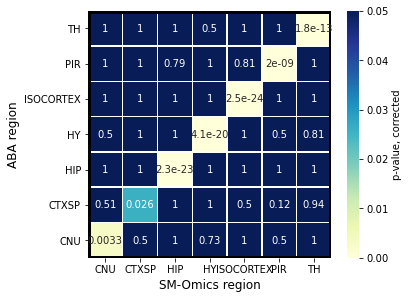

In [19]:
# Plot enrichement heatmap
fig = plt.figure(figsize=(20, 10)) 
ax1 = plt.subplot2grid((2, 2), (0, 0))
axes = [ax1]
num_cond = list(range(0, len(list(set(df_ff_t['condition'])))))
i=0

for condition, df in df_ff_t.groupby('condition'):
    # First make df into pivot table
    pivot_df = df.pivot(index='AAR_ST', columns='AAR_ABA', values='p-value, corrected').sort_index(axis = 0, ascending= False)
    
    # Might not be necessary for real values
    pivot_df = pivot_df.astype(str).astype(float) # For some unexpected reason, i get objects as dtype instead of integers, this is changed here. 
    
    # Plot
    ax=axes[num_cond[i]]
    vmin = 0
    vmax = 0.05
    sns.heatmap(pivot_df,annot=True, cmap="YlGnBu", ax=ax, vmin=vmin, vmax=vmax, linewidth = 0.5,cbar_kws={'label': 'p-value, corrected'})
    
    # Set axis labels
    ax.set_xlabel('SM-Omics region', fontsize=12)
    ax.set_ylabel('ABA region', fontsize=12)

    ax.axhline(y=0, color='k',linewidth=5)
    ax.axhline(y=pivot_df.shape[1], color='k',linewidth=5)
    ax.axvline(x=0, color='k',linewidth=5)
    ax.axvline(x=pivot_df.shape[0], color='k',linewidth=5)

    i+=1
    
#plt.show()
#fig.set_size_inches(12, 10)
#plt.savefig("../../figures/Visium_splotch_Heatmap.pdf")


# Print genes that are top most expressed in both ABA and SM-Omics per each region

In [ ]:
from collections import defaultdict
top_gene_dict = dict()
df = pd.DataFrame()
for k, v in ST_top_gene_dict.items():
    if k == 'nan':
        continue
  
    for i, STgene in enumerate([i.split("_")[0] for i in v]):
        for j, ABAgene in enumerate(ABA_top_gene_dict[k]):           
            if ABAgene == STgene:               
                top_gene_dict[STgene] = i+j

    df[k+'_genes'] = dict(sorted(top_gene_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]).keys()
    df[k+'_counts'] = dict(sorted(top_gene_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]).values()
    top_gene_dict = {}  
df